# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 10,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/'
             'completion_algo=(\S+)/'
             'measurement_percentage=(\d+\.\d+)/seed=(\d+)/'
             'lam=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        completion_algo = m.group(5)
        measurement_percentage = float(m.group(6))
        seed = int(m.group(7))
        l = float(m.group(8))
        logfile_paths.append((v100s, p100s, k80s, policy,
                              completion_algo, measurement_percentage,
                              seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
policy = "max_min_fairness_packed"
logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/keshav2/gpusched/scheduler/logs/2019-08-22/"))

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy,
          completion_algo, measurement_percentage,
          seed=None):
    if seed is None:
        return sorted([(x[7], x[8], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == completion_algo and
                       0.9 <= x[5] / measurement_percentage <= 1.1])
    else:
        return sorted([(x[7], x[8]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[7] == seed])

In [6]:
def plot_metric_vs_inverse_lambda(v100s, p100s, k80s,
                                  policy,
                                  completion_algos,
                                  measurement_percentage,
                                  metric_fn,
                                  metric_label,
                                  xmax=None,
                                  ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "completion_algo": []}
    completion_algos = ["Oracle"] + completion_algos
    for i, completion_algo in enumerate(completion_algos):
        if i == 0:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy,
                completion_algo='BMF', measurement_percentage=1.000000)))
        else:
            relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy,
            completion_algo, measurement_percentage)))
        lambdas = [x[0] for x in relevant_logfile_paths]
        input_job_rates = [3600.0 / x for x in lambdas]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        completion_algos = ["%s" % (completion_algo) for _ in range(len(metrics))]

        import pandas as pd
        data["input_job_rate"] += input_job_rates
        data["metric"] += metrics
        data["seed"] += seeds
        data["completion_algo"] += completion_algos

    sns.lineplot(x='input_job_rate', y='metric', style='completion_algo',
                 hue='completion_algo',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

# Plot average JCT versus input job rate

In [7]:
def average_jct_fn(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return None
    return np.mean(job_completion_times) / 3600

V100s=25, P100s=0, K80s=0; Jobs 4000-5000
measurement_percentage=0.857143


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


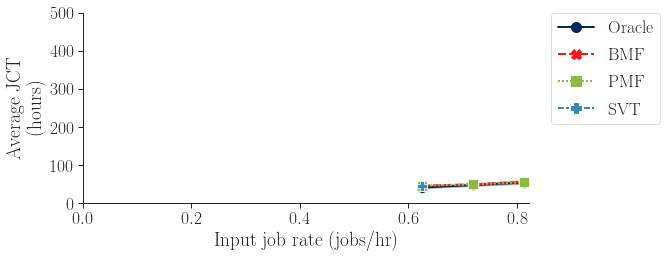

In [8]:
measurement_percentage = 0.857143
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
print("measurement_percentage=%f" % measurement_percentage)
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policy=policy,
    completion_algos=["BMF", "PMF", "SVT"],
    measurement_percentage=measurement_percentage,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0,
)

V100s=25, P100s=0, K80s=0; Jobs 4000-5000
measurement_percentage=0.714286


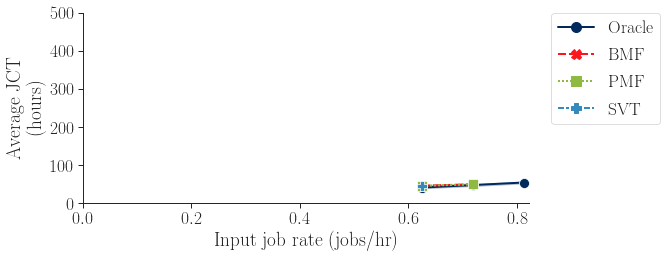

In [9]:
measurement_percentage = 0.714286
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
print("measurement_percentage=%f" % measurement_percentage)
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policy=policy,
    completion_algos=["BMF", "PMF", "SVT"],
    measurement_percentage=measurement_percentage,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0,
)

V100s=25, P100s=0, K80s=0; Jobs 4000-5000
measurement_percentage=0.571429


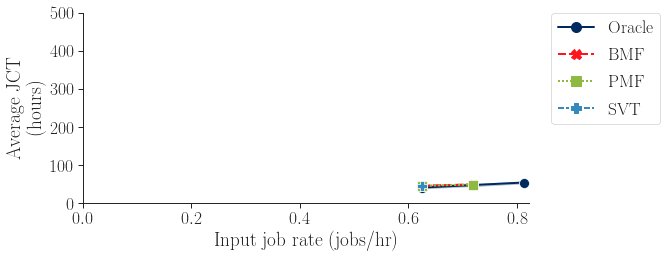

In [10]:
measurement_percentage = 0.571429
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
print("measurement_percentage=%f" % measurement_percentage)
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policy=policy,
    completion_algos=["BMF", "PMF", "SVT"],
    measurement_percentage=measurement_percentage,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0,
)

V100s=25, P100s=0, K80s=0; Jobs 4000-5000
measurement_percentage=0.428571


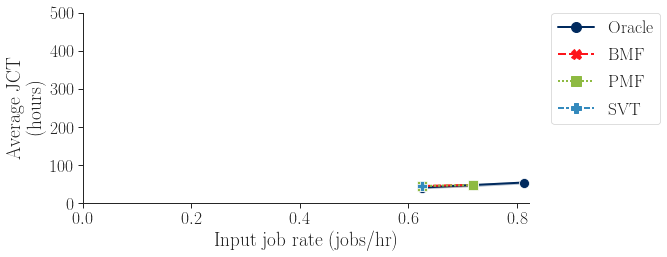

In [11]:
measurement_percentage = 0.428571
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
print("measurement_percentage=%f" % measurement_percentage)
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policy=policy,
    completion_algos=["BMF", "PMF", "SVT"],
    measurement_percentage=measurement_percentage,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0,
)

V100s=25, P100s=0, K80s=0; Jobs 4000-5000
measurement_percentage=0.285714


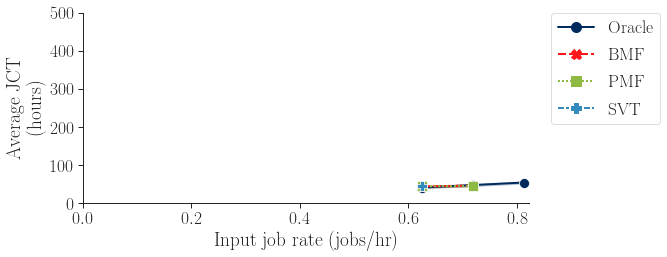

In [12]:
measurement_percentage = 0.285714
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
print("measurement_percentage=%f" % measurement_percentage)
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policy=policy,
    completion_algos=["BMF", "PMF", "SVT"],
    measurement_percentage=measurement_percentage,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0,
)

V100s=25, P100s=0, K80s=0; Jobs 4000-5000
measurement_percentage=0.142857


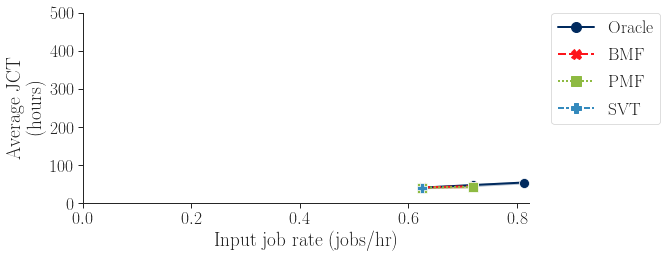

In [13]:
measurement_percentage = 0.142857
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
print("measurement_percentage=%f" % measurement_percentage)
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policy=policy,
    completion_algos=["BMF", "PMF", "SVT"],
    measurement_percentage=measurement_percentage,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0,
)